<a href="https://colab.research.google.com/github/amiskinis26/DATA_3000-Project/blob/main/DATA_3000_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Inporting libraries

In [1]:
import os
import pandas as pd
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

###Loading the dataset
Each of these variables helps describe the stated audio file. The file_id connects the data table to the audio files in the songs folder.

In [2]:
df = pd.read_csv('/content/drive/MyDrive/birdsong_metadata.csv')
df.head()

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/


Creating a dataset that solely consists of the file_id and the english name of the bird.

In [3]:
df1 = df[["file_id", "english_cname"]]
df1

,file_id,english_cname
0,132608,Common Redpoll
1,132611,Common Redpoll
2,35068,Common Redpoll
3,82715,Marsh Warbler
4,64685,Marsh Warbler
...,...,...
259,132392,Song Thrush
260,146756,Song Thrush
261,27060,Northern Lapwing
262,97982,Northern Lapwing


Creating a list of the 88 different species of birds.

In [4]:
classes = []
for x in df1["english_cname"]:
  if x not in classes:
    classes.append(x)

In [5]:
classes = [x.replace(" ", "_") for x in classes]
classes

['Common_Redpoll',
 'Marsh_Warbler',
 'Sedge_Warbler',
 'Eurasian_Reed_Warbler',
 'Long-tailed_Tit',
 'Eurasian_Skylark',
 'Meadow_Pipit',
 'Tree_Pipit',
 'Common_Swift',
 'Canada_Goose',
 'Dunlin',
 'European_Nightjar',
 'European_Goldfinch',
 'Eurasian_Treecreeper',
 'European_Greenfinch',
 'Black-headed_Gull',
 'Western_Jackdaw',
 'Rock_Dove',
 'Stock_Dove',
 'Common_Wood_Pigeon',
 'Northern_Raven',
 'Carrion_Crow',
 'Rook',
 'Common_Cuckoo',
 'Eurasian_Blue_Tit',
 'Common_House_Martin',
 'Great_Spotted_Woodpecker',
 'Black_Woodpecker',
 'Corn_Bunting',
 'Yellowhammer',
 'Common_Reed_Bunting',
 'European_Robin',
 'Common_Chaffinch',
 'Eurasian_Coot',
 'Common_Snipe',
 'Common_Moorhen',
 'Eurasian_Jay',
 'Red-throated_Loon',
 'Eurasian_Oystercatcher',
 'Barn_Swallow',
 'Eurasian_Wryneck',
 'Willow_Ptarmigan',
 'European_Herring_Gull',
 'Common_Linnet',
 'River_Warbler',
 'Red_Crossbill',
 'Common_Nightingale',
 'European_Bee-eater',
 'African_Pied_Wagtail',
 'Western_Yellow_Wagtail',

###Loading the audio files
This is creating a file path to the folder with all the audio files.

In [6]:
base = '/content/drive/MyDrive/songs/'

Creating 88 sub-folders so that there is a folder for each bird. This cell only needed to be run once. The changes done by it were saved and did not have to be done again.

In [7]:
from pathlib import Path
from pathlib import glob
base = '/content/drive/MyDrive/songs/'
for bird in classes:
  folder = Path(base+bird)
  folder.mkdir(parents = True)

ImportError: cannot import name 'glob' from 'pathlib' (/usr/lib/python3.10/pathlib.py)

Adding a "_" for every space in the bird's name in the dataset.

In [8]:
df1['english_cname'] = df1['english_cname'].str.replace(" ", "_")

<ipython-input-8-67d2465a654d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['english_cname'] = df1['english_cname'].str.replace(" ", "_")


In [9]:
df1

,file_id,english_cname
0,132608,Common_Redpoll
1,132611,Common_Redpoll
2,35068,Common_Redpoll
3,82715,Marsh_Warbler
4,64685,Marsh_Warbler
...,...,...
259,132392,Song_Thrush
260,146756,Song_Thrush
261,27060,Northern_Lapwing
262,97982,Northern_Lapwing


Sorting the audio files into their respective sub-folder.

In [10]:
files = Path(base).glob('*.flac')
for file in files:
    print(file.name.split(".")[0][2:])
    _species = df1.loc[
      df1['file_id'] == int(file.name.split(".")[0][2:]),
      'english_cname'].to_list()[0]
    print(_species)
    file.rename(Path(base)/_species/file.name)

Displaying sample waveplots and spectrograms (just to make sure everything previously runs correctly and smoothly).

<ipython-input-11-3841373a5291>:3: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y,sr=sr, x_axis='time', color='blue')


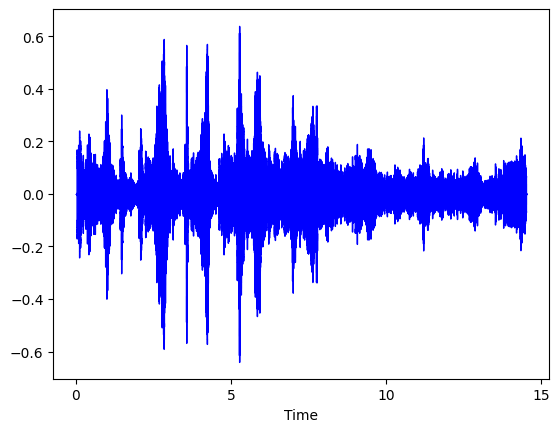

In [11]:
# please
y,sr=librosa.load('/content/drive/MyDrive/songs/Canada_Goose/xc35578.flac', sr= None)
librosa.display.waveshow(y,sr=sr, x_axis='time', color='blue')
#mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
#mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), (128,128))
#librosa.display.specshow(mel_spectrogram)
#type(mel_spectrogram)

Making a function that will create a spectrogram for each audio file, save it in a list (data), and save a list of a new variable -- bird id.

In [12]:
# Load and preprocess audio data
def load_and_preprocess_data(base, classes, target_shape=(128, 128)):
    data = []
    labels = []

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(base, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.flac'):
                file_path = os.path.join(class_dir, filename)
                audio_data, sample_rate = librosa.load(file_path, sr=None)
                # Perform preprocessing (e.g., convert to Mel spectrogram and resize)
                mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
                mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
                data.append(mel_spectrogram)
                labels.append(i)

    return np.array(data), np.array(labels)

Running the previously mentioned function on the actual data.

In [13]:
data, labels = load_and_preprocess_data(base, classes)

Splitting the data into training and testing sets. The split was stratified so that at least one audio file from each bird would be in both the training and testing datasets.

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

#labels = to_categorical(labels, num_classes=5)  # Convert labels to one-hot encoding
#X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.334, random_state=0)
#sss.get_n_splits(data, labels)

for i, (train_index, test_index) in enumerate(sss.split(data, labels)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

    X_train = [
        data[idx]
        for idx in range(len(data))
        if idx in train_index
    ]

    y_train = [
        labels[idx]
        for idx in range(len(labels))
        if idx in train_index
    ]

    X_test = [
        data[idx]
        for idx in range(len(data))
        if idx in test_index
    ]

    y_test = [
        labels[idx]
        for idx in range(len(labels))
        if idx in test_index
    ]

Fold 0:
  Train: index=[ 46 257 209 217 148  94 227  16  31 226 212  87 118  40  85 115 165 246
  20  70 150  55 194  82 219 193 223 242 224 196   4  60 136  23 146  71
 250 214 113 106  58 119 114  14  75 231 199 175  92  73 260  10   0  34
 216 158 263 198 249 167 228  96 254 186 202 164  72  79  39  67 205   7
  15  78 185 178   6 147  90 152   9  33 103 124  30 187 215  21  65 153
 234 173 112  98  83 183 180  18 233 105 110  28  48 131 247 191  86  12
  76 235 239  37 141 237 159  25  93 129 252  88 161 122 162  43 109 207
 145 230 137 143  61 125  64 138  27  59 128 240 169 100 177  66 211 155
 104   5 126  26 221 258  42  47 171 243 157 101  36 255 176 140 182  52
 170 195 204 120 190 261   2  54 201  49 133 245  51]
  Test:  index=[142  68 222 236  41  50 244 174  53  69   8  45 229  77 160 262 135  89
  44 232 213 184 166 220 151 134  35 154 200 181  57 111 116 168  81  63
 156 123 218  24  91  22 149 163 210 132  97  80  13  84  99 121 102 197
  19  17 206 238 189  74 117   1

Changing the format of the training and testing datasets so that the model will be able to read them clearly.

In [15]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [16]:
print(y_test)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87]


In [17]:
print(y_train)

[ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11
 12 12 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 23 23
 24 24 25 25 26 26 27 27 28 28 29 29 30 30 31 31 32 32 33 33 34 34 35 35
 36 36 37 37 38 38 39 39 40 40 41 41 42 42 43 43 44 45 45 46 46 47 47 48
 48 49 49 50 50 51 51 52 52 53 53 54 54 55 55 56 56 57 57 58 58 59 59 60
 60 61 61 62 62 63 63 64 64 65 65 66 66 67 67 68 68 69 69 70 70 71 71 72
 72 73 73 74 74 75 75 76 76 77 77 78 78 79 79 80 80 81 81 82 82 83 83 84
 84 85 85 86 86 87 87]


In [ ]:

y_train = pd.get_dummies(y_train).astype(int)
y_test = pd.get_dummies(y_test).astype(int)

###Creating the Model
Writing the code to form the shell of the CNN model: 2 convolutional layers, 2 max pooling layers, 2 dropout layers, a flatten and a dense layer. The activation function is 'softmax' which will make all the probabilities of a specific audio file (bird) be equal to 1. This will make it clearer which bird the model predicts.

In [ ]:
input_shape = (128,128,1)
input_layer = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.4)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(len(classes), activation='softmax')(x)
model = Model(input_layer, output_layer)

In [ ]:
input_shape

(128, 128, 1)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                        

###Training the Model

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=8, batch_size=3, validation_data=(X_test, y_test))

Epoch 1/8
59/59 [==============================] - 6s 106ms/step - loss: 0.4537 - accuracy: 0.9029 - val_loss: 13.7087 - val_accuracy: 0.0899
Epoch 2/8
59/59 [==============================] - 8s 139ms/step - loss: 0.3944 - accuracy: 0.9257 - val_loss: 16.4315 - val_accuracy: 0.0674
Epoch 3/8
59/59 [==============================] - 7s 115ms/step - loss: 0.2132 - accuracy: 0.9543 - val_loss: 17.0604 - val_accuracy: 0.0899
Epoch 4/8
59/59 [==============================] - 9s 145ms/step - loss: 0.1789 - accuracy: 0.9714 - val_loss: 18.0259 - val_accuracy: 0.0899
Epoch 5/8
59/59 [==============================] - 6s 110ms/step - loss: 0.2133 - accuracy: 0.9486 - val_loss: 19.9047 - val_accuracy: 0.0674
Epoch 6/8
59/59 [==============================] - 8s 143ms/step - loss: 0.1786 - accuracy: 0.9714 - val_loss: 19.8735 - val_accuracy: 0.0787
Epoch 7/8
59/59 [==============================] - 6s 109ms/step - loss: 0.1194 - accuracy: 0.9771 - val_loss: 23.6837 - val_accuracy: 0.0674
Epoch 

model accuracy

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.056179776787757874
